In [1]:
import pandas as pd
import numpy as np
import os
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score
import tempfile

c:\Users\andre\anaconda3\envs\tama\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
CATBOOST_TEMP_DIR = os.path.join(tempfile.gettempdir(), 'catboost_optuna_temp')
os.makedirs(CATBOOST_TEMP_DIR, exist_ok=True)

# 1. Defining Parameters

In [4]:
BASE_PATH = r".\Final_Graph"
EMBEDDINGS_PATH = os.path.join(BASE_PATH, "street_embeddings.csv")

# 2. Loading data

In [5]:
df = pd.read_csv(EMBEDDINGS_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73076 entries, 0 to 73075
Data columns (total 70 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_twi         73076 non-null  float64
 1   mean_slope       73076 non-null  float64
 2   mean_dist_river  73076 non-null  float64
 3   mm_len           73076 non-null  float64
 4   microbasin_id    49770 non-null  object 
 5   emb_0            73076 non-null  float64
 6   emb_1            73076 non-null  float64
 7   emb_2            73076 non-null  float64
 8   emb_3            73076 non-null  float64
 9   emb_4            73076 non-null  float64
 10  emb_5            73076 non-null  float64
 11  emb_6            73076 non-null  float64
 12  emb_7            73076 non-null  float64
 13  emb_8            73076 non-null  float64
 14  emb_9            73076 non-null  float64
 15  emb_10           73076 non-null  float64
 16  emb_11           73076 non-null  float64
 17  emb_12      

In [6]:
df.head()

,mean_twi,mean_slope,mean_dist_river,mm_len,microbasin_id,emb_0,emb_1,emb_2,emb_3,emb_4,...,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,flood_label
0,11.658583,0.002214,949.987079,47.959650,NaN,0.116140,-0.082956,-0.226614,-1.027807,-0.166408,...,0.013983,0.033108,-0.785686,0.170790,-0.156799,-0.566913,-0.202418,-0.871998,-0.158571,0
1,8.758889,0.023691,933.706659,86.537712,NaN,0.121264,-0.108964,-0.297386,-0.939309,-0.313890,...,0.014384,0.040581,-0.665502,0.095374,-0.254319,-0.715173,-0.298229,-0.797531,-0.024006,0
2,2.960323,0.100487,1013.908879,90.378377,NaN,0.264156,-0.258310,-0.177057,-1.163502,-0.110580,...,-0.021556,0.036559,-0.815705,0.286231,-0.166276,-0.619327,-0.171010,-0.932902,-0.286891,0
3,1.801311,0.080760,910.376321,74.583260,NaN,-0.030690,0.051304,-0.327333,-0.859235,-0.244105,...,0.009033,0.007645,-0.705565,0.073697,-0.103181,-0.497368,-0.269384,-0.884596,-0.015502,0
4,5.077661,0.127991,969.468580,81.130318,NaN,0.145109,-0.029248,-0.258517,-0.948409,-0.036202,...,0.006132,0.053734,-0.739799,0.212005,-0.029909,-0.482462,-0.181302,-0.816335,-0.115628,0


# 3. Training Data Prepatation

## 3.1. Removing Buffer Zones

In [7]:
list = ['1.2.4', '1.2.5', '1.3.1', '3.6.1', '3.6.2', '3.6.9', 'AC 1.2.4', 'AC 1.2.5', 'AC 1.3.2', 'NA']

df = df[~df['microbasin_id'].isin(list)]

df = df[~df['microbasin_id'].isnull()]

In [8]:
stats_microbacias = df.groupby('microbasin_id').agg(
    total_streets=('microbasin_id', 'size'), 
    flood_rate=('flood_label', 'mean'),
    flooded_streets=('flood_label', 'sum') 
)

total_dataset_ruas = len(df)

stats_microbacias['total_percentage'] = (
    stats_microbacias['total_streets'] / total_dataset_ruas
) * 100

stats_microbacias = stats_microbacias.sort_values(
    by='total_streets', 
    ascending=False
)

stats_microbacias['flood_rate'] = stats_microbacias['flood_rate'].map('{:.4f}'.format)
stats_microbacias['total_percentage'] = stats_microbacias['total_percentage'].map('{:.2f}%'.format)


print(stats_microbacias)

               total_streets flood_rate  flooded_streets total_percentage
microbasin_id                                                            
3.6.4                   8809     0.0210              185           20.21%
AC 1.1.12               7172     0.0609              437           16.45%
1.2.3                   5953     0.0408              243           13.65%
3.6.7                   5563     0.0582              324           12.76%
3.6.3                   4266     0.0019                8            9.78%
3.6.5                   2734     0.0037               10            6.27%
1.2.2                   2059     0.0238               49            4.72%
AC 1.2.2                1794     0.0184               33            4.11%
AC 3.6.7                1131     0.0955              108            2.59%
AC 3.6.3                 989     0.0202               20            2.27%
AC 3.6.6                 982     0.1079              106            2.25%
AC 3.6.5                 717     0.055

## 3.2. Defining Target Variable

In [10]:
X = df.drop(columns=['flood_label', 'microbasin_id'])
Y = df['flood_label']
groups = df['microbasin_id']

## 3.3. Train/Test Split

In [11]:
groups_for_test = [
    'AC 1.1.12'
]

is_test = groups.isin(groups_for_test)
is_train = ~is_test
X_train_geo = X[is_train]
Y_train_geo = Y[is_train]

X_test_geo = X[is_test]
Y_test_geo = Y[is_test]

print("\n--- Strategic Geographic Split Result ---")
print(f"Microbasins in the Test: {groups_for_test}")
print(f"X_train size: {len(X_train_geo)} streets ({len(X_train_geo)/len(X):.2%})")
print(f"X_test size: {len(X_test_geo)} streets ({len(X_test_geo)/len(X):.2%})")
print("-" * 40)
print(f"Proportion of label 1 (Flooding) in training: {Y_train_geo.mean():.4f}")
print(f"Proportion of label 1 (Flooding) in the test: {Y_test_geo.mean():.4f}")


--- Strategic Geographic Split Result ---
Microbasins in the Test: ['AC 1.1.12']
X_train size: 36426 streets (83.55%)
X_test size: 7172 streets (16.45%)
----------------------------------------
Proportion of label 1 (Flooding) in training: 0.0317
Proportion of label 1 (Flooding) in the test: 0.0609


In [12]:
groups_train = df.loc[X_train_geo.index, 'microbasin_id']
groups_test = df.loc[X_test_geo.index, 'microbasin_id']

df_train = pd.DataFrame({
    'set': 'Train', 
    'microbasin_id': groups_train, 
    'flood_label': Y_train_geo
})
df_test = pd.DataFrame({
    'set': 'Test', 
    'microbasin_id': groups_test, 
    'flood_label': Y_test_geo
})
df_combined = pd.concat([df_train, df_test], ignore_index=True)

aggregated_stats = df_combined.groupby('set').agg(
    total_streets=('microbasin_id', 'size'), 
    flood_rate=('flood_label', 'mean'), 
    flooded_streets=('flood_label', 'sum') 
).reset_index()

total_dataset_flooded = aggregated_stats['flooded_streets'].sum()

total_dataset_streets = aggregated_stats['total_streets'].sum()
aggregated_stats['percent_of_total_dataset'] = (
    aggregated_stats['total_streets'] / total_dataset_streets
) * 100
aggregated_stats['percent_of_total_flood'] = (
    aggregated_stats['flooded_streets'] / total_dataset_flooded
) * 100

aggregated_stats['flood_rate'] = aggregated_stats['flood_rate'].map('{:.4f}'.format)
aggregated_stats['percent_of_total_dataset'] = aggregated_stats['percent_of_total_dataset'].map('{:.2f}%'.format)
aggregated_stats['percent_of_total_flood'] = aggregated_stats['percent_of_total_flood'].map('{:.2f}%'.format)

aggregated_stats = aggregated_stats.sort_values(by='set', ascending=False)

aggregated_stats

,set,total_streets,flood_rate,flooded_streets,percent_of_total_dataset,percent_of_total_flood
1,Train,36426,0.0317,1155,83.55%,72.55%
0,Test,7172,0.0609,437,16.45%,27.45%


## 3.4. Groups for Cross Validation

In [13]:
FOLD_MAPPING = {
    '3.6.4': 1, 'AC 3.6.7': 1, 'AC 3.6.6': 1, 'AC 3.6.5': 1, 'AC 3.6.4': 1,
    '1.2.3': 2, '3.6.7': 2, 'AC 3.6.3': 2, 'AC 3.6.9': 2, 'AC 3.6.8': 2,
    '3.6.3': 3, '3.6.5': 3, '1.2.2': 3, 'AC 1.2.2': 3, 'AC 1.2.3': 3,
}

groups_cv = df.loc[X_train_geo.index, 'microbasin_id']
cv_groups = groups_cv.map(FOLD_MAPPING).values
cv_splitter = GroupKFold(n_splits=3)

In [16]:
GROUP_NAMES = {
    1: 'Fold 1 (CV Group)',
    2: 'Fold 2 (CV Group)',
    3: 'Fold 3 (CV Group)',
    99: 'Test Set (Hold-out)',
}

def calculate_group_metrics(labels: np.array, total_streets_dataset: int, total_floods_dataset: int) -> dict:
    
    total_streets = len(labels)
    flooded_streets = labels.sum()

    flood_rate = flooded_streets / total_streets if total_streets > 0 else 0

    percent_of_total_dataset = total_streets / total_streets_dataset if total_streets_dataset > 0 else 0

    percent_of_total_flood = flooded_streets / total_floods_dataset if total_floods_dataset > 0 else 0

    return {
        'total_streets': total_streets,
        'flooded_streets': flooded_streets,
        'flood_rate': flood_rate,
        'percent_of_total_dataset': percent_of_total_dataset,
        'percent_of_total_flood': percent_of_total_flood,
    }

total_streets_dataset = len(Y_train_geo) + len(Y_test_geo)
total_floods_dataset = Y_train_geo.sum() + Y_test_geo.sum()

results = {}

test_metrics = calculate_group_metrics(
    Y_test_geo, 
    total_streets_dataset, 
    total_floods_dataset
)
results[GROUP_NAMES[99]] = test_metrics

cv_group_ids = df.loc[Y_train_geo.index, 'microbasin_id'].map(FOLD_MAPPING)

for fold_id in [1, 2, 3]:
    group_mask = (cv_group_ids == fold_id)
    y_group = Y_train_geo[group_mask]
    
    fold_metrics = calculate_group_metrics(
        y_group,
        total_streets_dataset,
        total_floods_dataset
    )
    results[GROUP_NAMES[fold_id]] = fold_metrics


results_df = pd.DataFrame.from_dict(results, orient='index')

results_df['flood_rate'] = (results_df['flood_rate'] * 100).map('{:.2f}%'.format)
results_df['percent_of_total_dataset'] = (results_df['percent_of_total_dataset'] * 100).map('{:.2f}%'.format)
results_df['percent_of_total_flood'] = (results_df['percent_of_total_flood'] * 100).map('{:.2f}%'.format)

results_df['total_streets'] = results_df['total_streets'].astype(int)
results_df['flooded_streets'] = results_df['flooded_streets'].astype(int)

total_row = {
    'total_streets': total_streets_dataset,
    'flooded_streets': total_floods_dataset,
    'flood_rate': f'{total_floods_dataset / total_streets_dataset * 100:.2f}%',
    'percent_of_total_dataset': '100.00%',
    'percent_of_total_flood': '100.00%',
}
results_df.loc['Total Geral'] = total_row

results_df

,total_streets,flooded_streets,flood_rate,percent_of_total_dataset,percent_of_total_flood
Test Set (Hold-out),7172,437,6.09%,16.45%,27.45%
Fold 1 (CV Group),11802,444,3.76%,27.07%,27.89%
Fold 2 (CV Group),13385,604,4.51%,30.70%,37.94%
Fold 3 (CV Group),11239,107,0.95%,25.78%,6.72%
Total Geral,43598,1592,3.65%,100.00%,100.00%


# 4. Hyperparameter Tunning

In [17]:
def objective(trial):
    """
    Objective function for Optuna. Defines the hyperparameters to be tested
    and returns the performance metric (AUC) through cross-validation.
    """

    params = {
        'iterations': trial.suggest_int('iterations', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'random_seed': 42,
        'verbose': 0,
        'eval_metric': 'AUC',
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),
        'scale_pos_weight': (Y_train_geo == 0).sum() / (Y_train_geo == 1).sum(), 
    }

    model = CatBoostClassifier(**params, train_dir=CATBOOST_TEMP_DIR)

    score = cross_val_score(
        model,
        X_train_geo,
        Y_train_geo,
        cv=cv_splitter, 
        groups=cv_groups, 
        scoring='roc_auc',
        n_jobs=-1
    ).mean()

    return score

In [19]:
N_TRIALS = 50

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

best_params = study.best_params
print("\n---Optimization Results ---")
print(f"Best ROC_AUC: {study.best_value:.4f}")
print(f"Hyperparemeters: {best_params}")

[I 2025-12-04 08:34:10,627] A new study created in memory with name: no-name-976f9967-6b68-4286-89d9-b27df803286b
Best trial: 0. Best value: 0.735512:   2%|▏         | 1/50 [00:12<10:15, 12.56s/it]

[I 2025-12-04 08:34:23,194] Trial 0 finished with value: 0.7355115481760514 and parameters: {'iterations': 263, 'learning_rate': 0.03999042185330779, 'depth': 4, 'l2_leaf_reg': 3.8590627364953374e-07, 'subsample': 0.9246934626657042, 'min_data_in_leaf': 30}. Best is trial 0 with value: 0.7355115481760514.


Best trial: 0. Best value: 0.735512:   4%|▍         | 2/50 [00:35<14:55, 18.66s/it]

[I 2025-12-04 08:34:46,125] Trial 1 finished with value: 0.7113703657791349 and parameters: {'iterations': 248, 'learning_rate': 0.028439118150883094, 'depth': 7, 'l2_leaf_reg': 1.528768579309383e-08, 'subsample': 0.7908809576307071, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.7355115481760514.


Best trial: 0. Best value: 0.735512:   6%|▌         | 3/50 [00:53<14:16, 18.22s/it]

[I 2025-12-04 08:35:03,808] Trial 2 finished with value: 0.7107937794474469 and parameters: {'iterations': 163, 'learning_rate': 0.08315972641715101, 'depth': 7, 'l2_leaf_reg': 0.00014957792229262435, 'subsample': 0.9425056416109321, 'min_data_in_leaf': 22}. Best is trial 0 with value: 0.7355115481760514.


Best trial: 3. Best value: 0.779921:   8%|▊         | 4/50 [02:10<31:47, 41.48s/it]

[I 2025-12-04 08:36:20,935] Trial 3 finished with value: 0.7799207335318857 and parameters: {'iterations': 107, 'learning_rate': 0.03521100556584758, 'depth': 10, 'l2_leaf_reg': 1.9870937304405933e-07, 'subsample': 0.6244496167446902, 'min_data_in_leaf': 4}. Best is trial 3 with value: 0.7799207335318857.


Best trial: 4. Best value: 0.805348:  10%|█         | 5/50 [07:23<1:44:34, 139.44s/it]

[I 2025-12-04 08:41:34,068] Trial 4 finished with value: 0.8053484602338004 and parameters: {'iterations': 378, 'learning_rate': 0.02374937046114535, 'depth': 10, 'l2_leaf_reg': 3.791564680773902e-06, 'subsample': 0.6423537769951853, 'min_data_in_leaf': 21}. Best is trial 4 with value: 0.8053484602338004.


Best trial: 4. Best value: 0.805348:  12%|█▏        | 6/50 [07:34<1:10:07, 95.63s/it] 

[I 2025-12-04 08:41:44,662] Trial 5 finished with value: 0.7663585368445482 and parameters: {'iterations': 205, 'learning_rate': 0.060859651275120684, 'depth': 4, 'l2_leaf_reg': 2.025728668303699, 'subsample': 0.79406282805548, 'min_data_in_leaf': 9}. Best is trial 4 with value: 0.8053484602338004.


Best trial: 4. Best value: 0.805348:  14%|█▍        | 7/50 [07:47<49:23, 68.91s/it]  

[I 2025-12-04 08:41:58,557] Trial 6 finished with value: 0.7234729713163314 and parameters: {'iterations': 53, 'learning_rate': 0.09021191228955402, 'depth': 7, 'l2_leaf_reg': 0.0003710461852218764, 'subsample': 0.68953833659579, 'min_data_in_leaf': 1}. Best is trial 4 with value: 0.8053484602338004.


Best trial: 4. Best value: 0.805348:  16%|█▌        | 8/50 [08:26<41:35, 59.41s/it]

[I 2025-12-04 08:42:37,617] Trial 7 finished with value: 0.6663856623322513 and parameters: {'iterations': 353, 'learning_rate': 0.14448391486003273, 'depth': 7, 'l2_leaf_reg': 2.490580528692747e-07, 'subsample': 0.9694921355938287, 'min_data_in_leaf': 19}. Best is trial 4 with value: 0.8053484602338004.


Best trial: 4. Best value: 0.805348:  18%|█▊        | 9/50 [09:14<38:09, 55.84s/it]

[I 2025-12-04 08:43:25,615] Trial 8 finished with value: 0.7707428485529816 and parameters: {'iterations': 261, 'learning_rate': 0.021325353712267684, 'depth': 8, 'l2_leaf_reg': 7.343745871468458e-06, 'subsample': 0.6196449724471461, 'min_data_in_leaf': 14}. Best is trial 4 with value: 0.8053484602338004.


Best trial: 4. Best value: 0.805348:  20%|██        | 10/50 [09:24<27:41, 41.54s/it]

[I 2025-12-04 08:43:35,133] Trial 9 finished with value: 0.779953124754651 and parameters: {'iterations': 83, 'learning_rate': 0.04846672414868425, 'depth': 7, 'l2_leaf_reg': 0.1694753164235941, 'subsample': 0.6134490878800046, 'min_data_in_leaf': 26}. Best is trial 4 with value: 0.8053484602338004.


Best trial: 10. Best value: 0.809741:  22%|██▏       | 11/50 [15:58<1:37:12, 149.55s/it]

[I 2025-12-04 08:50:09,577] Trial 10 finished with value: 0.8097408354884257 and parameters: {'iterations': 468, 'learning_rate': 0.0113076276857221, 'depth': 10, 'l2_leaf_reg': 0.004664227187207345, 'subsample': 0.7337168850112655, 'min_data_in_leaf': 14}. Best is trial 10 with value: 0.8097408354884257.


Best trial: 10. Best value: 0.809741:  24%|██▍       | 12/50 [23:00<2:27:11, 232.41s/it]

[I 2025-12-04 08:57:11,523] Trial 11 finished with value: 0.807846584417374 and parameters: {'iterations': 496, 'learning_rate': 0.011482014166582148, 'depth': 10, 'l2_leaf_reg': 0.005357659488259377, 'subsample': 0.7144375887729277, 'min_data_in_leaf': 15}. Best is trial 10 with value: 0.8097408354884257.


Best trial: 12. Best value: 0.810944:  26%|██▌       | 13/50 [25:21<2:06:15, 204.74s/it]

[I 2025-12-04 08:59:32,580] Trial 12 finished with value: 0.8109441850948377 and parameters: {'iterations': 491, 'learning_rate': 0.013214779908028962, 'depth': 9, 'l2_leaf_reg': 0.013629950827955463, 'subsample': 0.7290435041995565, 'min_data_in_leaf': 13}. Best is trial 12 with value: 0.8109441850948377.


Best trial: 12. Best value: 0.810944:  28%|██▊       | 14/50 [28:09<1:56:03, 193.42s/it]

[I 2025-12-04 09:02:19,842] Trial 13 finished with value: 0.8055765011503128 and parameters: {'iterations': 483, 'learning_rate': 0.010090349309890341, 'depth': 9, 'l2_leaf_reg': 0.03918455019916971, 'subsample': 0.8660979079158333, 'min_data_in_leaf': 11}. Best is trial 12 with value: 0.8109441850948377.


Best trial: 12. Best value: 0.810944:  30%|███       | 15/50 [30:10<1:40:08, 171.68s/it]

[I 2025-12-04 09:04:21,133] Trial 14 finished with value: 0.8041999886700107 and parameters: {'iterations': 414, 'learning_rate': 0.015035241145111128, 'depth': 9, 'l2_leaf_reg': 0.004174244839979347, 'subsample': 0.7281305982951148, 'min_data_in_leaf': 8}. Best is trial 12 with value: 0.8109441850948377.


Best trial: 15. Best value: 0.843051:  32%|███▏      | 16/50 [32:05<1:27:35, 154.58s/it]

[I 2025-12-04 09:06:16,000] Trial 15 finished with value: 0.8430513807832064 and parameters: {'iterations': 433, 'learning_rate': 0.016889809733474093, 'depth': 9, 'l2_leaf_reg': 6.315830949465068, 'subsample': 0.7636485785798698, 'min_data_in_leaf': 18}. Best is trial 15 with value: 0.8430513807832064.


Best trial: 15. Best value: 0.843051:  34%|███▍      | 17/50 [33:07<1:09:38, 126.63s/it]

[I 2025-12-04 09:07:17,646] Trial 16 finished with value: 0.8246629745674613 and parameters: {'iterations': 320, 'learning_rate': 0.01821934876998313, 'depth': 8, 'l2_leaf_reg': 9.891132839840079, 'subsample': 0.8766413689277959, 'min_data_in_leaf': 18}. Best is trial 15 with value: 0.8430513807832064.


Best trial: 15. Best value: 0.843051:  36%|███▌      | 18/50 [33:25<50:13, 94.17s/it]   

[I 2025-12-04 09:07:36,263] Trial 17 finished with value: 0.8141388419362735 and parameters: {'iterations': 326, 'learning_rate': 0.017106580541210354, 'depth': 5, 'l2_leaf_reg': 9.28532569402151, 'subsample': 0.8608805525868812, 'min_data_in_leaf': 18}. Best is trial 15 with value: 0.8430513807832064.


Best trial: 15. Best value: 0.843051:  38%|███▊      | 19/50 [34:38<45:20, 87.75s/it]

[I 2025-12-04 09:08:49,065] Trial 18 finished with value: 0.8034573018220564 and parameters: {'iterations': 412, 'learning_rate': 0.019169627723410954, 'depth': 8, 'l2_leaf_reg': 0.4576794750058851, 'subsample': 0.8666411192082258, 'min_data_in_leaf': 25}. Best is trial 15 with value: 0.8430513807832064.


Best trial: 15. Best value: 0.843051:  40%|████      | 20/50 [35:01<34:06, 68.20s/it]

[I 2025-12-04 09:09:11,697] Trial 19 finished with value: 0.8152355983562471 and parameters: {'iterations': 310, 'learning_rate': 0.02789310106262057, 'depth': 6, 'l2_leaf_reg': 7.456522572853706, 'subsample': 0.8322415871733516, 'min_data_in_leaf': 17}. Best is trial 15 with value: 0.8430513807832064.


Best trial: 15. Best value: 0.843051:  42%|████▏     | 21/50 [36:19<34:28, 71.32s/it]

[I 2025-12-04 09:10:30,287] Trial 20 finished with value: 0.8207619010986859 and parameters: {'iterations': 426, 'learning_rate': 0.015796125995332054, 'depth': 8, 'l2_leaf_reg': 0.8793360836361996, 'subsample': 0.770757642972917, 'min_data_in_leaf': 25}. Best is trial 15 with value: 0.8430513807832064.


Best trial: 15. Best value: 0.843051:  44%|████▍     | 22/50 [37:36<34:05, 73.05s/it]

[I 2025-12-04 09:11:47,368] Trial 21 finished with value: 0.8094736711454313 and parameters: {'iterations': 421, 'learning_rate': 0.01567315708873764, 'depth': 8, 'l2_leaf_reg': 0.6327734412577467, 'subsample': 0.8149446512612208, 'min_data_in_leaf': 24}. Best is trial 15 with value: 0.8430513807832064.


Best trial: 15. Best value: 0.843051:  46%|████▌     | 23/50 [38:54<33:27, 74.36s/it]

[I 2025-12-04 09:13:04,778] Trial 22 finished with value: 0.8049144494104628 and parameters: {'iterations': 437, 'learning_rate': 0.024210237839958203, 'depth': 8, 'l2_leaf_reg': 0.10188334168189082, 'subsample': 0.7790064813848532, 'min_data_in_leaf': 30}. Best is trial 15 with value: 0.8430513807832064.


Best trial: 15. Best value: 0.843051:  48%|████▊     | 24/50 [40:57<38:38, 89.18s/it]

[I 2025-12-04 09:15:08,515] Trial 23 finished with value: 0.839356143611565 and parameters: {'iterations': 379, 'learning_rate': 0.018185573719877498, 'depth': 9, 'l2_leaf_reg': 1.9682700543364715, 'subsample': 0.7600129611135792, 'min_data_in_leaf': 21}. Best is trial 15 with value: 0.8430513807832064.


Best trial: 15. Best value: 0.843051:  50%|█████     | 25/50 [42:57<40:54, 98.19s/it]

[I 2025-12-04 09:17:07,734] Trial 24 finished with value: 0.812408731033586 and parameters: {'iterations': 361, 'learning_rate': 0.03555900166869042, 'depth': 9, 'l2_leaf_reg': 2.949241866233809, 'subsample': 0.8393603837376094, 'min_data_in_leaf': 20}. Best is trial 15 with value: 0.8430513807832064.


Best trial: 15. Best value: 0.843051:  52%|█████▏    | 26/50 [44:36<39:28, 98.68s/it]

[I 2025-12-04 09:18:47,563] Trial 25 finished with value: 0.8114623496743397 and parameters: {'iterations': 303, 'learning_rate': 0.02023285143117038, 'depth': 9, 'l2_leaf_reg': 0.13628576238111148, 'subsample': 0.8902888622791216, 'min_data_in_leaf': 17}. Best is trial 15 with value: 0.8430513807832064.


Best trial: 26. Best value: 0.845668:  54%|█████▍    | 27/50 [46:42<40:53, 106.66s/it]

[I 2025-12-04 09:20:52,825] Trial 26 finished with value: 0.8456675320095869 and parameters: {'iterations': 386, 'learning_rate': 0.01310642411124964, 'depth': 9, 'l2_leaf_reg': 8.884297933991453, 'subsample': 0.672582801691969, 'min_data_in_leaf': 23}. Best is trial 26 with value: 0.8456675320095869.


Best trial: 26. Best value: 0.845668:  56%|█████▌    | 28/50 [47:08<30:14, 82.47s/it] 

[I 2025-12-04 09:21:18,857] Trial 27 finished with value: 0.8118360619746167 and parameters: {'iterations': 382, 'learning_rate': 0.013327729179162232, 'depth': 6, 'l2_leaf_reg': 1.4209433340439241, 'subsample': 0.6677174773868294, 'min_data_in_leaf': 27}. Best is trial 26 with value: 0.8456675320095869.


Best trial: 26. Best value: 0.845668:  58%|█████▊    | 29/50 [49:31<35:16, 100.78s/it]

[I 2025-12-04 09:23:42,359] Trial 28 finished with value: 0.7466130232316351 and parameters: {'iterations': 454, 'learning_rate': 0.02858834423441781, 'depth': 9, 'l2_leaf_reg': 0.0006419915530163938, 'subsample': 0.7604576361343397, 'min_data_in_leaf': 22}. Best is trial 26 with value: 0.8456675320095869.


Best trial: 26. Best value: 0.845668:  60%|██████    | 30/50 [54:33<53:43, 161.17s/it]

[I 2025-12-04 09:28:44,455] Trial 29 finished with value: 0.7996769482586722 and parameters: {'iterations': 395, 'learning_rate': 0.04456885668334588, 'depth': 10, 'l2_leaf_reg': 0.034724384755045405, 'subsample': 0.6843645901077952, 'min_data_in_leaf': 28}. Best is trial 26 with value: 0.8456675320095869.


Best trial: 26. Best value: 0.845668:  62%|██████▏   | 31/50 [56:20<45:51, 144.79s/it]

[I 2025-12-04 09:30:31,015] Trial 30 finished with value: 0.8256720903655262 and parameters: {'iterations': 336, 'learning_rate': 0.012783022326090942, 'depth': 9, 'l2_leaf_reg': 0.39444251608502157, 'subsample': 0.659275744638006, 'min_data_in_leaf': 23}. Best is trial 26 with value: 0.8456675320095869.


Best trial: 26. Best value: 0.845668:  64%|██████▍   | 32/50 [58:16<40:50, 136.14s/it]

[I 2025-12-04 09:32:26,972] Trial 31 finished with value: 0.8252572339709138 and parameters: {'iterations': 342, 'learning_rate': 0.013152159558328252, 'depth': 9, 'l2_leaf_reg': 0.4859267959711052, 'subsample': 0.6511048066779027, 'min_data_in_leaf': 23}. Best is trial 26 with value: 0.8456675320095869.


Best trial: 26. Best value: 0.845668:  66%|██████▌   | 33/50 [1:00:16<37:12, 131.30s/it]

[I 2025-12-04 09:34:26,970] Trial 32 finished with value: 0.8382953528551388 and parameters: {'iterations': 378, 'learning_rate': 0.010085640608384487, 'depth': 9, 'l2_leaf_reg': 2.9106538820747043, 'subsample': 0.700069228304832, 'min_data_in_leaf': 28}. Best is trial 26 with value: 0.8456675320095869.


Best trial: 26. Best value: 0.845668:  68%|██████▊   | 34/50 [1:04:11<43:20, 162.52s/it]

[I 2025-12-04 09:38:22,328] Trial 33 finished with value: 0.8439473604310014 and parameters: {'iterations': 290, 'learning_rate': 0.010818732828887598, 'depth': 10, 'l2_leaf_reg': 3.4653599451235504, 'subsample': 0.7512445482266048, 'min_data_in_leaf': 28}. Best is trial 26 with value: 0.8456675320095869.


Best trial: 34. Best value: 0.858696:  70%|███████   | 35/50 [1:07:19<42:29, 169.97s/it]

[I 2025-12-04 09:41:29,703] Trial 34 finished with value: 0.858695810719178 and parameters: {'iterations': 238, 'learning_rate': 0.014684058117787384, 'depth': 10, 'l2_leaf_reg': 4.807375483495182, 'subsample': 0.7650706072893202, 'min_data_in_leaf': 29}. Best is trial 34 with value: 0.858695810719178.


Best trial: 34. Best value: 0.858696:  72%|███████▏  | 36/50 [1:10:14<40:03, 171.67s/it]

[I 2025-12-04 09:44:25,326] Trial 35 finished with value: 0.8203995450354805 and parameters: {'iterations': 216, 'learning_rate': 0.011471438079448374, 'depth': 10, 'l2_leaf_reg': 3.975842456093536e-05, 'subsample': 0.7463581100216036, 'min_data_in_leaf': 29}. Best is trial 34 with value: 0.858695810719178.


Best trial: 34. Best value: 0.858696:  74%|███████▍  | 37/50 [1:14:05<41:04, 189.55s/it]

[I 2025-12-04 09:48:16,611] Trial 36 finished with value: 0.8540399993847866 and parameters: {'iterations': 286, 'learning_rate': 0.01475032963848601, 'depth': 10, 'l2_leaf_reg': 4.13744253077173, 'subsample': 0.8032923080589155, 'min_data_in_leaf': 30}. Best is trial 34 with value: 0.858695810719178.


Best trial: 34. Best value: 0.858696:  76%|███████▌  | 38/50 [1:17:10<37:37, 188.12s/it]

[I 2025-12-04 09:51:21,375] Trial 37 finished with value: 0.8169071140749314 and parameters: {'iterations': 225, 'learning_rate': 0.014472844573756008, 'depth': 10, 'l2_leaf_reg': 0.04366336539942314, 'subsample': 0.8088231709309053, 'min_data_in_leaf': 30}. Best is trial 34 with value: 0.858695810719178.


Best trial: 34. Best value: 0.858696:  78%|███████▊  | 39/50 [1:19:21<31:19, 170.91s/it]

[I 2025-12-04 09:53:32,124] Trial 38 finished with value: 0.8352594717797821 and parameters: {'iterations': 162, 'learning_rate': 0.024553100509046792, 'depth': 10, 'l2_leaf_reg': 0.20895726312007654, 'subsample': 0.7916959405444708, 'min_data_in_leaf': 27}. Best is trial 34 with value: 0.858695810719178.


Best trial: 34. Best value: 0.858696:  80%|████████  | 40/50 [1:23:05<31:09, 186.98s/it]

[I 2025-12-04 09:57:16,603] Trial 39 finished with value: 0.807101056422194 and parameters: {'iterations': 277, 'learning_rate': 0.011649257865773819, 'depth': 10, 'l2_leaf_reg': 1.5883944540844742e-08, 'subsample': 0.7069661313373319, 'min_data_in_leaf': 29}. Best is trial 34 with value: 0.858695810719178.


Best trial: 34. Best value: 0.858696:  82%|████████▏ | 41/50 [1:26:47<29:35, 197.29s/it]

[I 2025-12-04 10:00:57,952] Trial 40 finished with value: 0.8483422100864441 and parameters: {'iterations': 278, 'learning_rate': 0.07088364163490211, 'depth': 10, 'l2_leaf_reg': 2.7484715596252993, 'subsample': 0.9179331414841425, 'min_data_in_leaf': 26}. Best is trial 34 with value: 0.858695810719178.


Best trial: 34. Best value: 0.858696:  84%|████████▍ | 42/50 [1:30:29<27:17, 204.65s/it]

[I 2025-12-04 10:04:39,794] Trial 41 finished with value: 0.8423654006889234 and parameters: {'iterations': 285, 'learning_rate': 0.08793668384473902, 'depth': 10, 'l2_leaf_reg': 3.134767847679752, 'subsample': 0.9560500297162527, 'min_data_in_leaf': 26}. Best is trial 34 with value: 0.858695810719178.


Best trial: 34. Best value: 0.858696:  86%|████████▌ | 43/50 [1:32:52<21:43, 186.16s/it]

[I 2025-12-04 10:07:02,788] Trial 42 finished with value: 0.8339436321227739 and parameters: {'iterations': 177, 'learning_rate': 0.06780836540106647, 'depth': 10, 'l2_leaf_reg': 1.374158396851317, 'subsample': 0.9157686175786617, 'min_data_in_leaf': 28}. Best is trial 34 with value: 0.858695810719178.


Best trial: 34. Best value: 0.858696:  88%|████████▊ | 44/50 [1:36:00<18:41, 186.88s/it]

[I 2025-12-04 10:10:11,367] Trial 43 finished with value: 0.8315655699208214 and parameters: {'iterations': 244, 'learning_rate': 0.11956503382507194, 'depth': 10, 'l2_leaf_reg': 3.710878901067413, 'subsample': 0.9177086901060619, 'min_data_in_leaf': 30}. Best is trial 34 with value: 0.858695810719178.


Best trial: 34. Best value: 0.858696:  90%|█████████ | 45/50 [1:39:12<15:42, 188.44s/it]

[I 2025-12-04 10:13:23,446] Trial 44 finished with value: 0.8294349675254787 and parameters: {'iterations': 241, 'learning_rate': 0.07213492434567256, 'depth': 10, 'l2_leaf_reg': 1.1066350153089148, 'subsample': 0.9984297866489668, 'min_data_in_leaf': 26}. Best is trial 34 with value: 0.858695810719178.


Best trial: 34. Best value: 0.858696:  92%|█████████▏| 46/50 [1:42:51<13:10, 197.56s/it]

[I 2025-12-04 10:17:02,269] Trial 45 finished with value: 0.7456930042112319 and parameters: {'iterations': 289, 'learning_rate': 0.11219226606920915, 'depth': 10, 'l2_leaf_reg': 9.053937364141249e-07, 'subsample': 0.8228050618252358, 'min_data_in_leaf': 25}. Best is trial 34 with value: 0.858695810719178.


Best trial: 34. Best value: 0.858696:  94%|█████████▍| 47/50 [1:45:21<09:09, 183.21s/it]

[I 2025-12-04 10:19:32,010] Trial 46 finished with value: 0.829719997126458 and parameters: {'iterations': 192, 'learning_rate': 0.0496740698250208, 'depth': 10, 'l2_leaf_reg': 0.34256587646392506, 'subsample': 0.6016250448128992, 'min_data_in_leaf': 27}. Best is trial 34 with value: 0.858695810719178.


Best trial: 34. Best value: 0.858696:  96%|█████████▌| 48/50 [1:47:21<05:28, 164.15s/it]

[I 2025-12-04 10:21:31,699] Trial 47 finished with value: 0.8415160825426923 and parameters: {'iterations': 147, 'learning_rate': 0.022070149111855678, 'depth': 10, 'l2_leaf_reg': 3.4646694782455025, 'subsample': 0.6767121558755226, 'min_data_in_leaf': 4}. Best is trial 34 with value: 0.858695810719178.


Best trial: 34. Best value: 0.858696:  98%|█████████▊| 49/50 [1:47:34<01:58, 118.98s/it]

[I 2025-12-04 10:21:45,268] Trial 48 finished with value: 0.8154639943958143 and parameters: {'iterations': 258, 'learning_rate': 0.010173824172848123, 'depth': 4, 'l2_leaf_reg': 0.11003334267514643, 'subsample': 0.7391138894222482, 'min_data_in_leaf': 29}. Best is trial 34 with value: 0.858695810719178.


Best trial: 34. Best value: 0.858696: 100%|██████████| 50/50 [1:48:56<00:00, 130.72s/it]

[I 2025-12-04 10:23:06,619] Trial 49 finished with value: 0.7554852209564568 and parameters: {'iterations': 263, 'learning_rate': 0.05599999278810153, 'depth': 9, 'l2_leaf_reg': 0.0008787311977701518, 'subsample': 0.6380273797170828, 'min_data_in_leaf': 23}. Best is trial 34 with value: 0.858695810719178.

---Optimization Results ---
Best ROC_AUC: 0.8587
Hyperparemeters: {'iterations': 238, 'learning_rate': 0.014684058117787384, 'depth': 10, 'l2_leaf_reg': 4.807375483495182, 'subsample': 0.7650706072893202, 'min_data_in_leaf': 29}


# 5. Model Training

In [22]:
final_params = best_params
final_params['random_seed'] = 42
final_params['verbose'] = 100
final_params['scale_pos_weight'] = (Y_train_geo == 0).sum() / (Y_train_geo == 1).sum()

final_model = CatBoostClassifier(**final_params)
final_model.fit(X_train_geo, Y_train_geo)

0:	learn: 0.6792958	total: 363ms	remaining: 1m 25s
100:	learn: 0.1568352	total: 31.4s	remaining: 42.6s
200:	learn: 0.0786211	total: 1m 4s	remaining: 11.9s
237:	learn: 0.0648532	total: 1m 16s	remaining: 0us


# 6. Model Evaluation

In [23]:
Y_pred_proba = final_model.predict_proba(X_test_geo)[:, 1]
Y_pred = final_model.predict(X_test_geo)

auc = roc_auc_score(Y_test_geo, Y_pred_proba)
f1 = f1_score(Y_test_geo, Y_pred)
accuracy = accuracy_score(Y_test_geo, Y_pred)

print("\n--- FINAL MODEL EVALUATION TEST METRICS ---")
print(f"ROC AUC: {auc:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")


--- FINAL MODEL EVALUATION TEST METRICS ---
ROC AUC: 0.6885
F1-Score: 0.2553
Accuracy: 0.9357


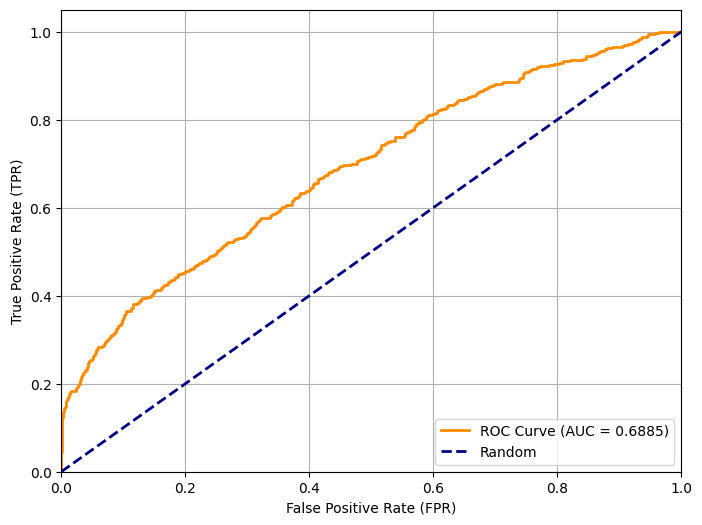

In [24]:
THRESHOLD = 0.5


fpr, tpr, thresholds = roc_curve(Y_test_geo, Y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

<Figure size 700x700 with 0 Axes>

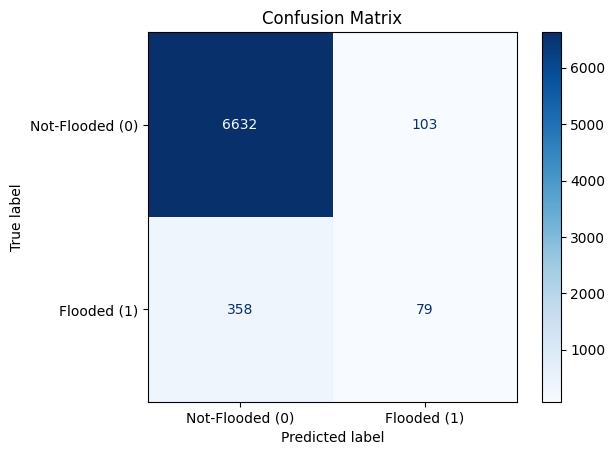

In [25]:
cm = confusion_matrix(Y_test_geo, Y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Not-Flooded (0)', 'Flooded (1)']
)

plt.figure(figsize=(7, 7))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

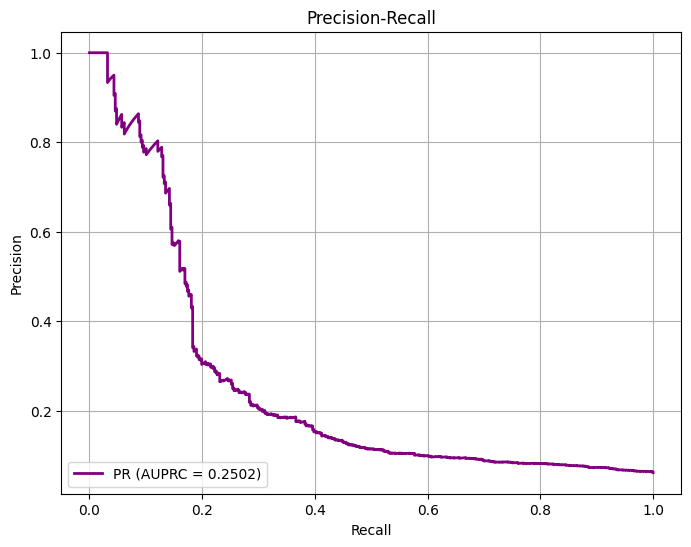

In [26]:
precision, recall, _ = precision_recall_curve(Y_test_geo, Y_pred_proba)

auprc = average_precision_score(Y_test_geo, Y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR (AUPRC = {auprc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

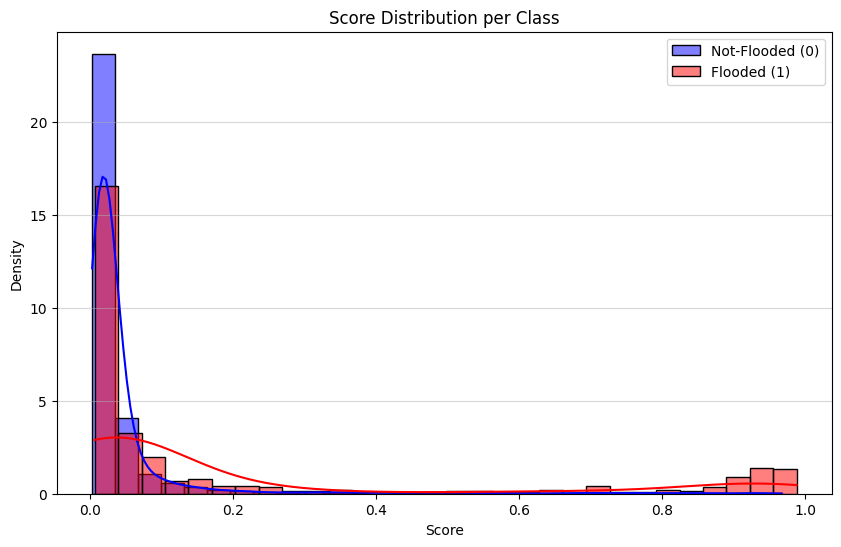

In [27]:
plt.figure(figsize=(10, 6))

sns.histplot(Y_pred_proba[Y_test_geo == 0], bins=30, kde=True, color="blue", label="Not-Flooded (0)", stat="density")
sns.histplot(Y_pred_proba[Y_test_geo == 1], bins=30, kde=True, color="red", label="Flooded (1)", stat="density")

plt.title('Score Distribution per Class')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

# 7. Feature Importance

In [28]:
final_model.get_feature_importance(prettified=True)[0:10]

,Feature Id,Importances
0,mean_dist_river,16.457811
1,emb_5,4.611635
2,emb_17,3.952901
3,emb_12,2.285832
4,emb_27,2.274671
5,emb_50,2.261603
6,emb_58,1.956647
7,mm_len,1.938355
8,emb_63,1.861067
9,emb_35,1.822659


C:\Users\andre\AppData\Local\Temp\ipykernel_42856\1539478420.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="viridis")


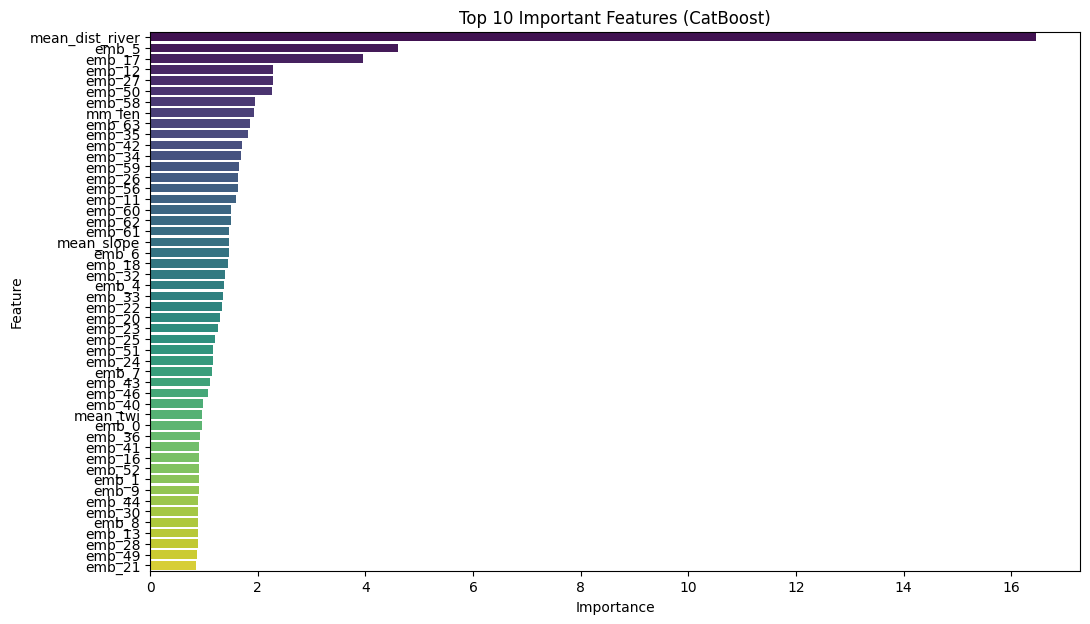

In [29]:
feature_importance = pd.Series(final_model.get_feature_importance(prettified=False))
feature_importance.index = X_train_geo.columns
feature_importance = feature_importance.sort_values(ascending=False).head(50)

plt.figure(figsize=(12, 7))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="viridis")
plt.title('Top 10 Important Features (CatBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()